# Examples and tests for xcorr_tools

## Setup

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits
import scipy.interpolate

import sys
sys.path.append("../src/")
import pseudo_Cls
import utils

pi = np.pi

## Test power spectrum routines

Make sure pseudo Cl estimator and Gaussian randomfield creator are consistent. Also check that the total variance matches.

First create a number of random Gaussian noise realisation with a given power spectrum.

In [2]:
# Physical size of the map in radians
L = 10/180*pi
# Resolution (i.e. 500x500)
n = 500

# Minimum ell when binning
ell_min = 100
# Maximum ell when binning
ell_max = 2*pi/L*n/2
# Number of ell bins
n_bin = 5
# Use log-spaced bins
logspaced = True

# Number of realisations
n_realisation = 50

def spectrum(ell):
    """Create a simply power spectrum with a peak at ell = 500."""
    ell_0 = 500
    return 1/(ell/ell_0*(1+(ell/ell_0)**2))
    #return ell**-1
    #return np.ones_like(ell)

pCl = np.zeros((n_realisation, n_bin))

for i in range(n_realisation):
    random_map = pseudo_Cls.create_Gaussian_field(spectrum, (n, n), (L, L))
    Cl, Cl_err, ell_mean, bin_edges, _ = pseudo_Cls.calculate_pseudo_Cl(random_map, random_map, (L, L), 
                                         n_bin=n_bin, ell_min=ell_min, ell_max=ell_max, logspaced=logspaced)
    pCl[i] = Cl

And plot the results.

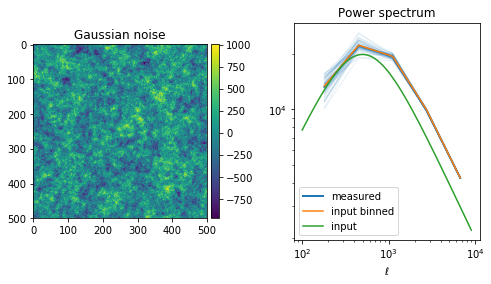

In [3]:
fig, plots = plt.subplots(1, 2, figsize=(8, 4))
fig.subplots_adjust(wspace=0.4)

im = plots[0].imshow(random_map, interpolation="nearest")
utils.subplot_colorbar(im, plots[0])
plots[0].set_title("Gaussian noise")

units = ell_mean*(ell_mean+1)/(2*pi)

Cl = np.mean(pCl, axis=0)
Cl_err = np.sqrt(np.var(pCl, axis=0)/n_realisation)

plots[1].loglog(ell_mean, (units*pCl).T, c="C0", alpha=0.1, lw=1)
plots[1].loglog(ell_mean, units*Cl, label="measured", lw=2)

ell = np.arange(ell_min, ell_max+1)
Cl_theory, _, _ = utils.bin_array(spectrum(ell), ell, bin_edges=bin_edges, weights=ell)
plots[1].loglog(ell_mean, units*Cl_theory, label="input binned")

units = ell*(ell+1)/(2*pi)

plots[1].loglog(ell, units*spectrum(ell), label="input")
plots[1].legend()
plots[1].set_xlabel(r"$\ell$")

_ = plots[1].set_title("Power spectrum")


Check that the variance of the created map matches the integral of the measured Cl and input Cl.

In [4]:
map_var = np.zeros(n_realisation)
pCl_var = np.zeros(n_realisation)

for i in range(n_realisation):
    random_map = pseudo_Cls.create_Gaussian_field(spectrum, (n, n), (L, L))
    Cl, Cl_err, ell_mean, bin_edges, _ = pseudo_Cls.calculate_pseudo_Cl(random_map, random_map, (L, L), n_bin=None)
    map_var[i] = np.var(random_map)
    pCl_var[i] = np.trapz(ell_mean*Cl, ell_mean)/(2*pi)

print("Map variance:       {}".format(utils.format_value_pm_error(np.mean(map_var), 
                                                                  np.std(map_var)/np.sqrt(n_realisation),
                                                                  precision=2)))
print("Pseudo Cl variance: {}".format(utils.format_value_pm_error(np.mean(pCl_var), 
                                                                  np.std(pCl_var)/np.sqrt(n_realisation),
                                                                  precision=2)))
ell = np.arange(ell_mean[0], ell_mean[-1])
print("Input Cl variance:  {}".format(utils.format_value_pm_error(np.sum((2*ell+1)*spectrum(ell))/(4*pi),
                                                                  precision=2,
                                                                  width=4)))

Map variance:       5.70±0.03 10^4
Pseudo Cl variance: 5.62±0.03 10^4
Input Cl variance:  5.76      10^4


## Map processing

The function `pseudo_Cls.process_map` provides a number of operations that can be used to process maps. The first example shows how to add Gaussian random noise to a map, smooth it, and downsample it to a resolution that is easier to deal with in a subsequent analysis. 

In [5]:
# Function to plot the maps and power spectra.
def make_plots(map1, map2, Cl1, Cl2, plots):
    im = plots[0].imshow(map1, interpolation="nearest")
    utils.subplot_colorbar(im, plots[0])
    plots[0].set_title("Original map")

    im = plots[1].imshow(map2, interpolation="nearest")
    utils.subplot_colorbar(im, plots[1])
    plots[1].set_title("Processed map")


    ell = Cl1[2]
    units = ell*(ell+1)/(2*pi)
    plots[2].loglog(ell, units*Cl1[0], label="Original")
    plots[2].fill_between(ell, units*(Cl1[0]-Cl1[1]), 
                               units*(Cl1[0]+Cl1[1]),
                               alpha=0.5)

    ell = Cl2[2]
    units = ell*(ell+1)/(2*pi)
    plots[2].loglog(ell, units*Cl2[0], label="Processed")
    plots[2].fill_between(ell, units*(Cl2[0]-Cl2[1]), 
                               units*(Cl2[0]+Cl2[1]),
                               alpha=0.5)

    plots[2].legend()

    plots[2].set_xlabel(r"$\ell$")
    plots[2].set_ylabel(r"$\ell(\ell+1)/2\pi C_\ell$")
    plots[2].set_title("Power spectra")

### Shape noise, smoothing, and downsampling

Adding Gaussian noise.
Smoothing: sigma = 0.0014544410433286077, mode = wrap.
Zoom: (1800, 1800) -> (300, 300)


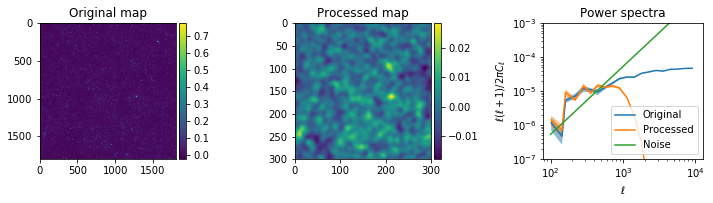

In [6]:
# Physical size of the map. For the BAHAMAS map used here, that is 5 degree
L = 5/180*pi
# Downsampling factor
zoom_factor = 6
# Smoothing scale
smoothing_scale = 5/60/180*pi # 5 arcmin in radian

# Weak lensing shape noise
sigma_e = 0.28
n_eff = 20.0
Cl_shape_noise = lambda ell: np.ones_like(ell)*sigma_e**2/(n_eff*60**2/(1/180*pi)**2)

# Binning parameters
n_bin = 20
ell_min = 100
ell_max = 10000
logspaced = True

# Load map
with astropy.io.fits.open("./data/AGN_TUNED_nu0_L400N1024_WMAP9_cone_0_kappa_kids_image_ngp.fits") as hdu:
    kappa_map = hdu[0].data    

# Process map
processed_kappa_map, new_map_size = pseudo_Cls.process_map(m=kappa_map, 
                                                           processes=[
                                                                {"type" : "gaussian_noise", "spectrum" : Cl_shape_noise},
                                                                {"type" : "smoothing", "sigma" : smoothing_scale, "mode" : "wrap"},
                                                                {"type" : "zoom", "zoom_factor" : 1/zoom_factor},
                                                                    ],
                                                            map_size=(L, L),
                                                            verbose=True)

# Calculate power spectra
kappa_map_pCl = pseudo_Cls.calculate_pseudo_Cl(kappa_map, kappa_map, (L, L), 
                                               n_bin=n_bin, ell_min=ell_min, ell_max=ell_max, logspaced=logspaced)
processed_kappa_map_pCl = pseudo_Cls.calculate_pseudo_Cl(processed_kappa_map, processed_kappa_map, (L, L), 
                                                         n_bin=n_bin, ell_min=ell_min, ell_max=ell_max, logspaced=logspaced)

# Plot things

fig, plots = plt.subplots(1, 3, figsize=(12, 2.5))
fig.subplots_adjust(wspace=0.6)

make_plots(kappa_map, processed_kappa_map, kappa_map_pCl, processed_kappa_map_pCl, plots)

ell = np.linspace(ell_min, ell_max, 100)
units = ell*(ell+1)/(2*pi)
plots[2].loglog(ell, units*Cl_shape_noise(ell), label="Noise")

plots[2].set_ylim(1.0e-7, 1.0e-3)
_ = plots[2].legend()

### CMB lensing noise and downsampling

Similar to the previous example but using CMB lensing instead. The noise spectrum is taken from Planck. It is currently being extrapolated beyond 2048. To avoid this, downsampling the map first would be an option.

Adding Gaussian noise.
Zoom: (1800, 1800) -> (300, 300)


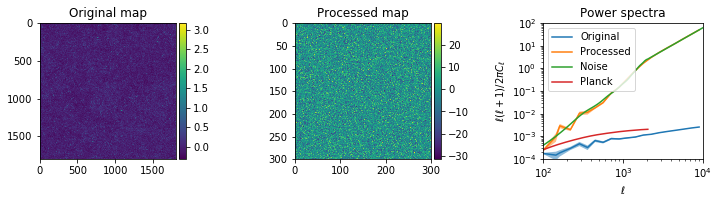

In [7]:
# CMB lensing noise
ell_Planck_data, N_ell_raw, N_C_ell_raw = np.loadtxt("./data/nlkk.dat", unpack=True)
Cl_CMB_noise = scipy.interpolate.UnivariateSpline(ell_Planck_data, N_ell_raw, s=0, k=1, ext=3)

# Load map
with astropy.io.fits.open("./data/AGN_TUNED_nu0_L400N1024_WMAP9_cone_0_kappa_CMB_image_ngp.fits") as hdu:
    kappa_map = hdu[0].data    

# Process map
processed_kappa_map, new_map_size = pseudo_Cls.process_map(m=kappa_map, 
                                                           processes=[
                                                                {"type" : "gaussian_noise", "spectrum" : Cl_CMB_noise},
                                                                {"type" : "zoom", "zoom_factor" : 1/zoom_factor},
                                                                    ],
                                                            map_size=(L, L),
                                                            verbose=True)

# Calculate power spectra
kappa_map_pCl = pseudo_Cls.calculate_pseudo_Cl(kappa_map, kappa_map, (L, L), 
                                               n_bin=n_bin, ell_min=ell_min, ell_max=ell_max, logspaced=logspaced)

processed_kappa_map_pCl = pseudo_Cls.calculate_pseudo_Cl(processed_kappa_map, processed_kappa_map, (L, L), 
                                                         n_bin=n_bin, ell_min=ell_min, ell_max=ell_max, logspaced=logspaced)

# Plot things
fig, plots = plt.subplots(1, 3, figsize=(12, 2.5))
fig.subplots_adjust(wspace=0.6)

make_plots(kappa_map, processed_kappa_map, kappa_map_pCl, processed_kappa_map_pCl, plots)

ell = np.logspace(np.log10(ell_min), np.log10(ell_max), 100)
units = ell*(ell+1)/(2*pi)
plots[2].loglog(ell, units*Cl_CMB_noise(ell), label="Noise")

ell = ell_Planck_data
units = ell*(ell+1)/(2*pi)
plots[2].loglog(ell, units*(N_C_ell_raw-N_ell_raw), label="Planck")

plots[2].set_ylim(1.0e-4, 1.0e2)
plots[2].set_xlim(ell_min, ell_max)
_ = plots[2].legend()